# Prototyping Models w/ PyTorch

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.datasets
import sklearn.linear_model
import torch
from torch.nn import Sequential, Linear, ReLU, MSELoss

from chmp.torch_util import (
    TorchModel, 
    linear, 
    WeightsHS,
    LossHistory,
    NllLoss,
    NormalModelConstantScale, 
    KLDivergence,
    Transformer,
    SimpleBayesTorchModel,
    iter_batch_indices,
)

In [2]:
# create a regression data set
x, y = sklearn.datasets.make_regression(
    n_samples=1_000, 
    n_features=10, 
    n_informative=2, 
    shuffle=False, 
    random_state=42_42_42,
)

# with redudant features
x = np.concatenate([x, x], axis=1)

In [3]:
print(x.shape)

(1000, 20)


In [4]:
class LinearHS(NormalModelConstantScale):
    def __init__(self, in_features, out_features, tau_0, bias=True):
        super().__init__()
        
        self.weights = WeightsHS((in_features, out_features), tau_0=tau_0)
        self.bias = torch.nn.Parameter(torch.zeros(1)) if bias else 0
        
    def transform(self, x):
        return self.bias + linear(x, self.weights())
    
    def kl_divergence(self):
        return self.weights.kl_divergence()

In [5]:
n_samples, n_features = x.shape

## Linear regression model with horeshoe prior

See C. Louizos, K. Ullrich, and M. Welling, "[Bayesian Compression for Deep Learning](https://arxiv.org/abs/1705.08665)" (2017).

Use Horseshoe prior on the weights:

$$
\begin{align}
    s_a \sim &\mathcal{G}(0, \tau_0^2) \\
    s_b^{-1} &\sim \mathcal{G}(0, 1/2) \\
    \alpha_{ij} &\sim \mathcal{G}(0, 1/2) \\
    \beta^{-1}_{ij} &\sim \mathcal{G}(0, 1/2) \\
    \tilde{w}_{ij} &\sim \mathcal{N}(0, 1) \\
    w_{ij} &= \tilde{w}_{ij} \sqrt{s_a / s_b} \sqrt{\alpha / \beta}
\end{align}
$$

Use the variational approximation:
$$
\begin{align}
    q(s_a) &= \mathcal{LN}(\dots) \\
    q(s_b^{-1}) &= \mathcal{LN}(\dots) \\
    q(\alpha_{ij}) &= \mathcal{LN}(\dots) \\
    q(\beta_{ij}^-{1}) &= \mathcal{LN}(\dots) \\
    q(\tilde{w}_{ij}) &= \mathcal{N}(\dots) \\
\end{align}
$$

In [6]:
def mse_loss(pred, y):
    loc, _ = pred
    return torch.mean((loc - y) ** 2.0)

In [7]:
model = SimpleBayesTorchModel(
    module=LinearHS(n_features, 1, tau_0=1e-5),
    n_observations=n_samples,
    optimizer_kwargs=dict(lr=1e-2),
)

loss_history = LossHistory()
model.fit(
    x, y, epochs=1_000, verbose=True, callbacks=[loss_history], 
    metrics=[mse_loss],
    validation_data=(x, y),
)

[done. took 3m 5s] 1.85 mse_loss: 0.0938 (999 / 1,000)                                                                  



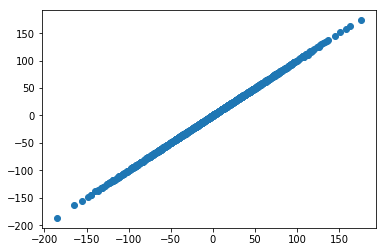

In [8]:
y_pred_loc, y_pred_scale = model.predict(x.astype('float32'))
plt.scatter(y, y_pred_loc)

/Volumes/Home/.local/share/virtualenvs/misc-exp-8XcdncOT/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
/Volumes/Home/.local/share/virtualenvs/misc-exp-8XcdncOT/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


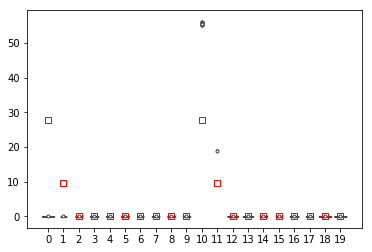

In [9]:
linear_coefs = sklearn.linear_model.LinearRegression().fit(x, y).coef_
weights = np.concatenate([model.module.weights().detach().numpy() for _ in range(100)], axis=1)

sns.violinplot(data=weights.T)
plt.plot(linear_coefs, 's', markeredgecolor='r', markerfacecolor='none')

## Attention

Use an attention model of the form

$$
\begin{align}
    \alpha_{ij} &= q(x_i)^T k(x_j) \\
    p_{ij} &= \mathrm{softmax}(\alpha_{ij}, \mathrm{mask}) \\
    \hat{y}_i &= \sum_j p_{ij} v(x_j, y_j)
\end{align}
$$

In [10]:
def transform_x(indices):
    mask = np.ones((len(indices), len(x)))
    mask[np.arange(len(indices)), indices] = 0

    np.testing.assert_allclose(np.sum(mask, axis=1), (len(x) - 1))

    return {
        'search_x': x.astype('float32'),
        'search_y': y.astype('float32'),
        'query_x': x[indices].astype('float32'),
        'mask': mask
    }


def transform_xy(indices):
    batch_x = transform_x(indices)
    batch_y = y[indices].astype('float32') 
    return batch_x, batch_y

In [11]:
module = Transformer(
    key_module=torch.nn.Sequential(
        Linear(n_features, 20),
        ReLU(),
        Linear(20, 20),
        ReLU(),
    ),
)
model = TorchModel(
    module=module,
    loss=MSELoss(),
    optimizer='Adam',
    optimizer_kwargs=dict(lr=1e-2),
)

model.fit_transformed(
    range(len(x)), transform_xy, batch_size=20, dtype=None, epochs=10, verbose=True,
)

[done. took 4.89s] 4.3 (9 / 10)                                                                                         



[done. took 0.20s] predict                                                                                              



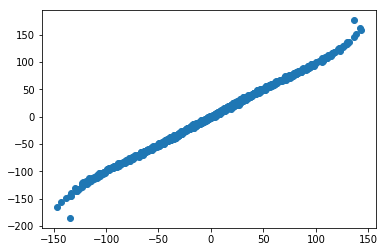

In [12]:
y_pred = model.predict_transformed(range(len(x)), transform_x, batch_size=20, dtype=None, verbose=True)
plt.scatter(y_pred, y)